In [152]:
import numpy as np
import matplotlib.pyplot as plt


In [237]:

def find_neigbours(size):
    assert size%2 == 0, "size must be even"
    # Only nearest neighbours
    a_neighbours = np.zeros((size,2),dtype=int)
    for i in range(size):
        a_neighbours[i,0] = (i+1)%size
        a_neighbours[i,1] = (i-1)%size

    is_done = False
    while not is_done:
        is_done = True
        b_neighbours = -np.ones((size,4),dtype=int)
        b_neighbours[:,0:2] = a_neighbours.copy()

        possible_nbs = np.arange(size)
        np.random.shuffle(possible_nbs)
        for i in range(size):
            all_except_self_and_nbs = possible_nbs[possible_nbs != i]
            all_except_self_and_nbs = all_except_self_and_nbs[all_except_self_and_nbs not in b_neighbours[i]]
            if len(all_except_self_and_nbs) == 0 or len(all_except_self_and_nbs[0]) == 0:
                is_done = False
                break
            nb = np.random.choice(all_except_self_and_nbs[0])
            b_neighbours[i,2] = nb
            b_neighbours[nb,3] = i

            possible_nbs = possible_nbs[possible_nbs != nb]



    return a_neighbours, b_neighbours


C:\Users\jakob\AppData\Local\Temp\ipykernel_14672\3585086600.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  all_except_self_and_nbs = all_except_self_and_nbs[all_except_self_and_nbs not in b_neighbours[i]]


(array([[1, 5],
        [2, 0],
        [3, 1],
        [4, 2],
        [5, 3],
        [0, 4]]),
 array([[1, 5, 3, 1],
        [2, 0, 0, 4],
        [3, 1, 4, 5],
        [4, 2, 5, 0],
        [5, 3, 1, 2],
        [0, 4, 2, 3]]))

In [203]:
J = 1.0


def order_param(lattice):
    return np.abs(np.sum(lattice)/len(lattice))

def E_full(lattice):
    return -J * np.sum(lattice * np.roll(lattice, 1, axis=0))

def E(site, lrest):
    return -J * site * lrest.sum()

def x_fun(site, lrest, T):
    return np.exp(2*E(site,lrest)*(1/T))

def flip(lattice, x):
    lattice[x] *= -1

def flip_maybe(lattice, neighbours, T):
    x = np.random.randint(0, neighbours.shape[0])
    
    indexs = neighbours[x]

    li = lattice[indexs]

    xf = x_fun(lattice[x], li, T)

    if np.random.random() < xf: # maybe .copy() or .ravel()
        flip(lattice, x)

def Jspace(n):
    return np.concatenate((np.linspace(0.1,1,n-1, endpoint=False),np.linspace(1,10,n, endpoint=True)))

def run(neighbours, T, n_runs):
    lattice = np.random.choice([-1,1], size = neighbours.shape[0])
    for i in range(n_runs):
        flip_maybe(lattice, neighbours, T)
    return lattice


def get_order_param(neighbours, T, n_runs, transient):
    lattice = np.random.choice([-1,1], size = neighbours.shape[0])

    order_params = np.zeros(n_runs-transient)
    for i in range(n_runs):
        flip_maybe(lattice, neighbours, T)
        if i > transient:
            order_params[i-transient] = order_param(lattice)
            
    return np.cumsum(order_params)/(n_runs-transient)

def sweep_T(size, n_runs):
    a_neighbours, b_neighbours = find_neigbours(size)
    order_params = np.zeros((2,2*10-1))
    for ii, nei in enumerate([a_neighbours, b_neighbours]):
        print(ii)
        for i, T in enumerate(Jspace(10)):
            order_params[ii,i] = get_order_param(b_neighbours, T, n_runs+1000, transient=1000)[-1]
            # print(f"T: {T:.1f} <s>: {order_param(lattice):.3f}")
            # plt.imshow(np.repeat(lattice, 50,axis=0).reshape(size,50).T,cmap='gray',interpolation='none')
            # plt.show()
    
    return order_params



# sizes = [100, 500, 1000, 5000, 10000, 50000]
# for size in sizes:
#     n_runs = 10000
#     print(f"size: {size}")
#     binarysearch_4_T(size, n_runs)

plot the order parameter ⟨si⟩ vs. T

In [204]:
order_params = sweep_T(100, 100000)

0
1


In [169]:
order_params_a = order_params[0]
order_params_b = order_params[1]


In [171]:
order_params_a

array([-1.  ,  1.  , -1.  ,  0.22, -0.86,  0.16,  0.2 ,  0.46,  0.38,
       -0.28, -0.04,  0.04,  0.  ,  0.12, -0.12, -0.18,  0.22, -0.1 ,
        0.08])

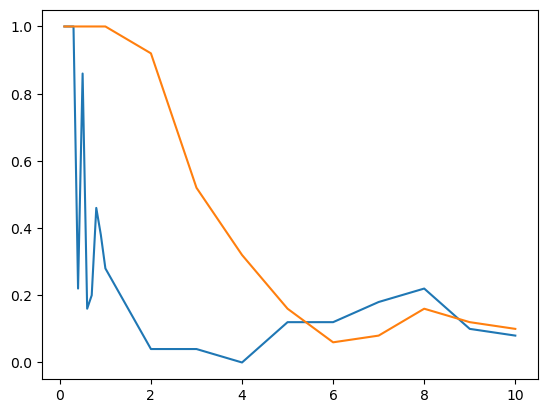

In [174]:
plt.plot(Jspace(10), np.abs(order_params_a), label="a")
plt.plot(Jspace(10), np.abs(order_params_b), label="b")

In [194]:
def binarysearch_4_T(size, n_runs):
    max_t = 5
    min_t = 0.1
    T = (max_t+min_t)/2
    for i in range(20):
        T = (max_t+min_t)/2
        a_neighbours, b_neighbours = find_neigbours(size)
        lattice = run(b_neighbours, T, n_runs)

        op = np.abs(order_param(lattice))
        if op < 0.99:
            max_t = T+0.1
        else:
            min_t = T-0.1


    print(f"Found T: {T:.3f} <s>: {op:.3f}")
    less, more = T-0.1, T+0.1
    # more_lattice = run(b_neighbours, more, n_runs)
    # less_lattice = run(b_neighbours, less, n_runs)
    # more_op = np.abs(order_param(more_lattice))
    # less_op = np.abs(order_param(less_lattice))
    # print("T-0.1 <s>: ", less_op)
    # print("T+0.1 <s>: ", more_op)
    # print("")
    return T, op

In [197]:
Ts = []
for N in (50, 100, 500, 1000, 5000, 10000, 50000):
    T, op = binarysearch_4_T(100, 100000)
    Ts.append(T)

Found T: 1.674 <s>: 0.980
Found T: 1.299 <s>: 1.000
Found T: 1.715 <s>: 1.000
Found T: 1.966 <s>: 0.940
Found T: 1.515 <s>: 0.940
Found T: 1.246 <s>: 1.000
Found T: 1.274 <s>: 0.980


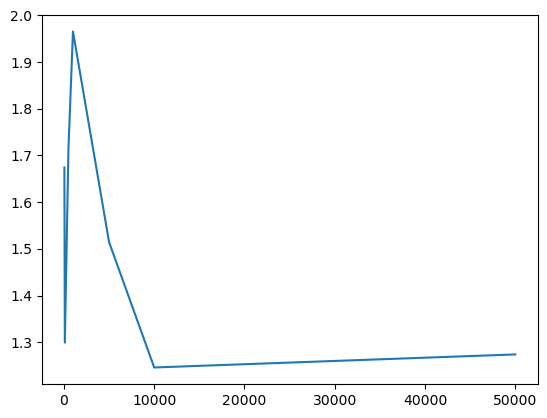

In [198]:
plt.plot([50, 100, 500, 1000, 5000, 10000, 50000], Ts)